# Data Prepraration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import warnings
import shutil
from skimage.transform import resize
from skimage.exposure import rescale_intensity
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps
from shutil import copyfile

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
folder_path = r'C:\Users\BoonJane\Desktop\oralcancer\Original' 
class_names = ['Normal', 'Hyperchromasia', 'Atypical mitotic figure', 'Abnormal variation in nuclear shape'] 

In [4]:
data = pd.DataFrame(columns=['file', 'class'])

for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(folder_path, class_name)
    files = os.listdir(class_folder)

    # run all files and add it into dataframe
    for file_name in files:
        file_path = os.path.join(class_folder, file_name)
        data = data.append({'file': file_path, 'class': class_index}, ignore_index=True)

In [5]:
print(data.head(220)) 

                                                  file class
0    C:\Users\BoonJane\Desktop\oralcancer\Original\...     0
1    C:\Users\BoonJane\Desktop\oralcancer\Original\...     0
2    C:\Users\BoonJane\Desktop\oralcancer\Original\...     0
3    C:\Users\BoonJane\Desktop\oralcancer\Original\...     0
4    C:\Users\BoonJane\Desktop\oralcancer\Original\...     0
..                                                 ...   ...
215  C:\Users\BoonJane\Desktop\oralcancer\Original\...     3
216  C:\Users\BoonJane\Desktop\oralcancer\Original\...     3
217  C:\Users\BoonJane\Desktop\oralcancer\Original\...     3
218  C:\Users\BoonJane\Desktop\oralcancer\Original\...     3
219  C:\Users\BoonJane\Desktop\oralcancer\Original\...     3

[220 rows x 2 columns]


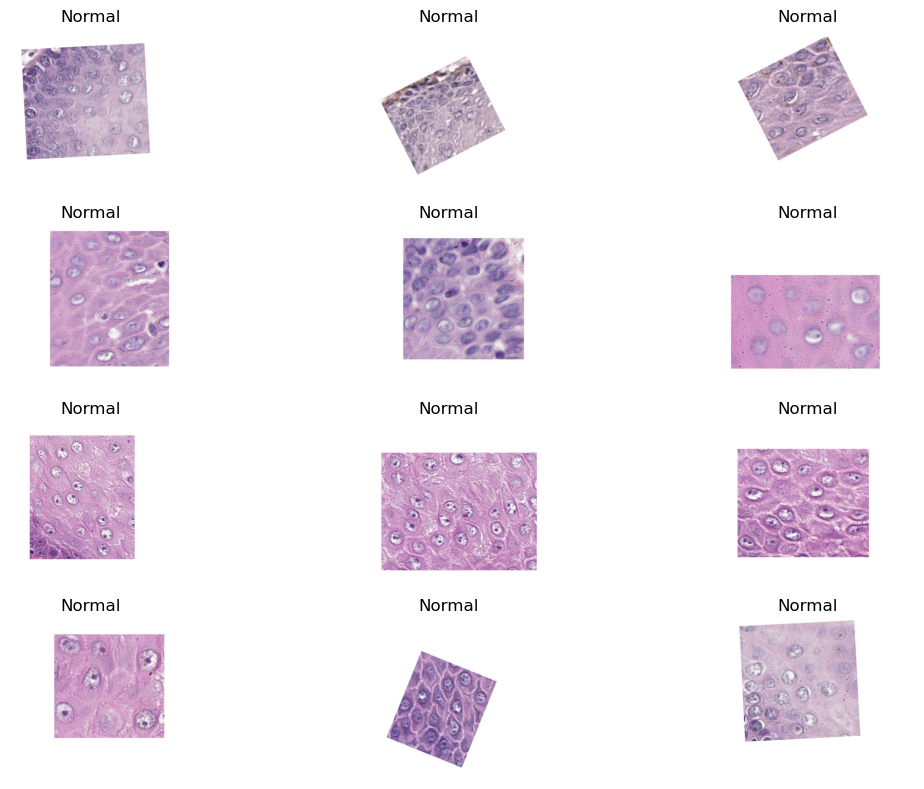

In [8]:
# show images with class name
def show_image_with_class(image_path, class_name, ax):
    
    image = Image.open(image_path)
    ax.imshow(image)   
    ax.set_title(class_name)
    ax.axis('off')

num_images = 12
num_cols = 3  
num_rows = (num_images + num_cols - 1) // num_cols 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

axes = axes.ravel()

for i, (index, row) in enumerate(data.iterrows()):
    image_path = row['file']
    class_name = class_names[row['class']]
    
    if i < num_images and i < num_cols * num_rows:
        show_image_with_class(image_path, class_name, axes[i])

plt.tight_layout()
plt.show()


# Image Preprocessing

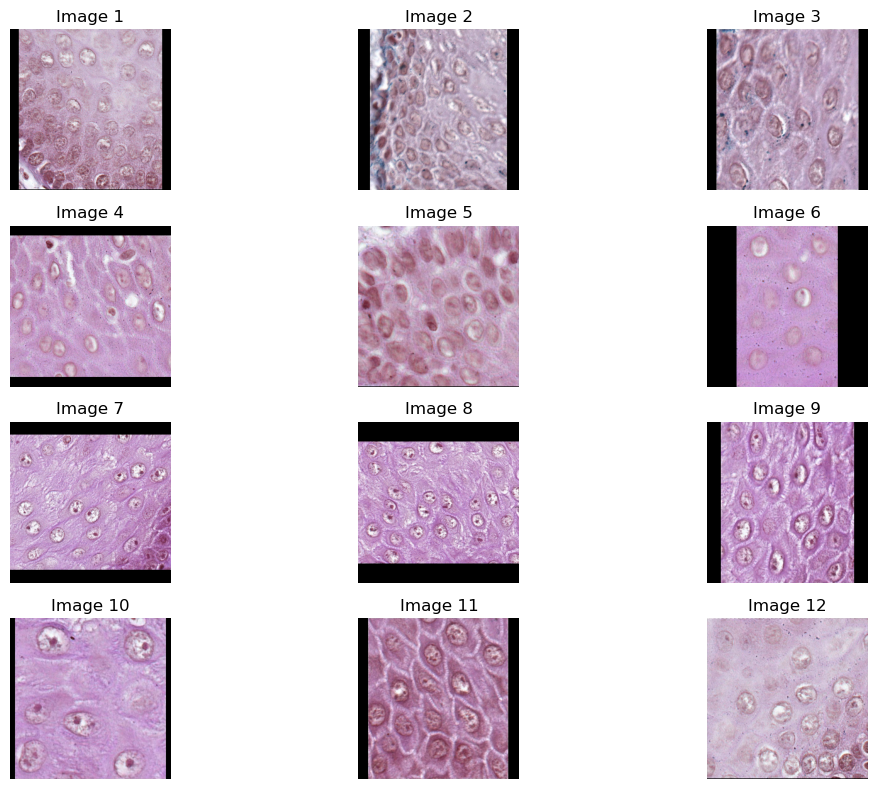

In [9]:
# correct the images to be a square or rectangle 
def deskew_image(image):
    image = np.array(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(contour)
    angle = rect[-1]
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    corrected_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return corrected_image

# normalize image
def normalize_image(image):
    image = image.astype('uint8')
    normalized_image = image.astype('float32') / 255.0
    normalized_image = (normalized_image * 255.0).astype('uint8')
    
    return normalized_image

# remove white border
def remove_white_border(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)
    removeborder_image = image[y:y+h, x:x+w]
    return removeborder_image

def resize_image(image, target_size):
    # Resize image while maintaining aspect ratio
    height, width = image.shape[:2]
    target_height, target_width = target_size

    # Compute scaling factor for resizing
    scale = min(target_height / height, target_width / width)

    # Compute new dimensions for resizing
    new_height = int(height * scale)
    new_width = int(width * scale)

    # Resize image
    resized_image = cv2.resize(image, (new_width, new_height))

    # Perform cropping or padding as needed
    if new_height < target_height or new_width < target_width:
        top_pad = (target_height - new_height) // 2
        bottom_pad = target_height - new_height - top_pad
        left_pad = (target_width - new_width) // 2
        right_pad = target_width - new_width - left_pad

        resized_image = cv2.copyMakeBorder(
            resized_image,
            top_pad,
            bottom_pad,
            left_pad,
            right_pad,
            cv2.BORDER_CONSTANT,
            value=(0, 0, 0)  # Black padding
        )

    return resized_image

resized_images = []

for image_path in data['file']:
    image = cv2.imread(image_path)
    corrected_image = deskew_image(image)
    normalized_image = normalize_image(corrected_image)
    removeborder_image = remove_white_border(normalized_image)
    resized_image = resize_image(removeborder_image, (256, 256))
    resized_images.append(resized_image)

data['rgb_image'] = resized_images

# show the preprocessed images
start_index = 0
end_index = 11 

num_images = end_index - start_index + 1
fig, axes = plt.subplots(4, 3, figsize=(12, 8))

axes = axes.ravel()

for i in range(num_images):
    axes[i].imshow(data['rgb_image'][start_index + i])
    axes[i].axis('off')
    axes[i].set_title(f'Image {start_index + i + 1}')

plt.tight_layout()
plt.show()

### RGB Image Dataset

In [10]:
# save the resized image with its class to local path
rgbc_path = r'C:\Users\BoonJane\Desktop\oralcancer\RGBimage'
class_names = ['Normal', 'Hyperchromasia', 'Atypical mitotic figure', 'Abnormal variation in nuclear shape'] 

for i, (resized_image, image_class) in enumerate(zip(data['rgb_image'], data['class'])):
    
    class_name = class_names[image_class] 
    save_dir = os.path.join(rgbc_path, class_name)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"image_{i}.jpg")

    cv2.imwrite(save_path, resized_image)

In [11]:
# convert rgb to grayscale
def grayscale(image):

    image = np.array(image, dtype=np.uint8)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = gray_image.astype('float32')
    
    return gray_image

data['grayscale_image'] = data['rgb_image'].apply(grayscale)

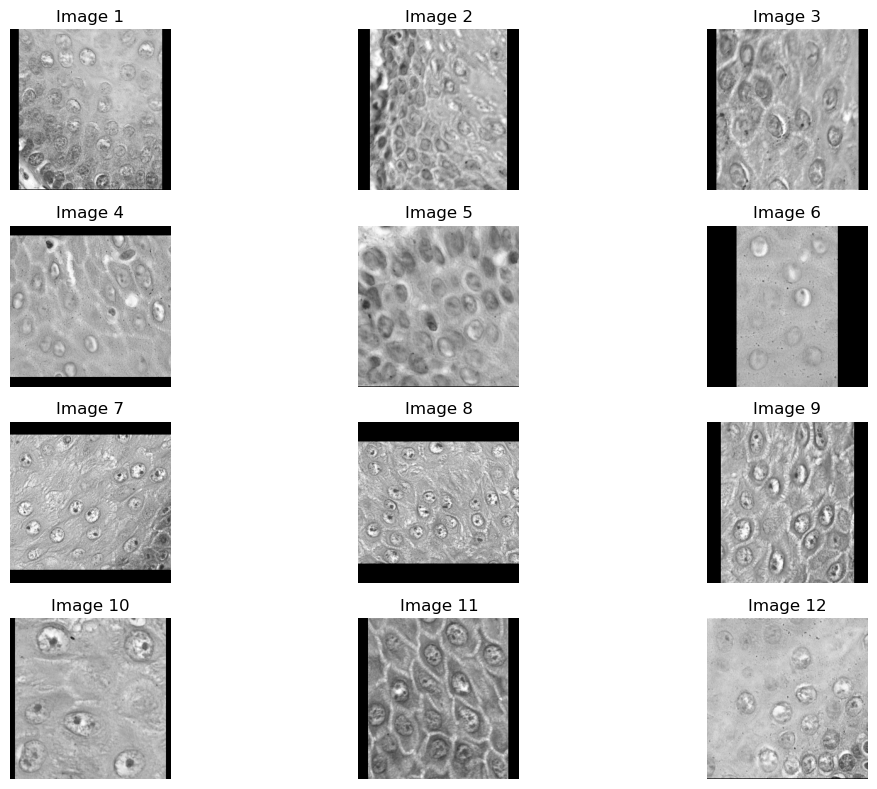

In [12]:
# show grayscaled images
start_index = 0
end_index = 11  

num_images = end_index - start_index + 1
fig, axes = plt.subplots(4, 3, figsize=(12, 8))

axes = axes.ravel()

for i in range(num_images):
    axes[i].imshow(data['grayscale_image'][start_index + i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Image {start_index + i + 1}')

plt.tight_layout()
plt.show()

### Grayscale Image Dataset

In [11]:
# save the resized image with its class to local path
grayscalec_path = r'C:\Users\BoonJane\Desktop\oralcancer\Grayscaleimage'
class_names = ['Normal', 'Hyperchromasia', 'Atypical mitotic figure', 'Abnormal variation in nuclear shape'] 

for i, (gray_image, image_class) in enumerate(zip(data['grayscale_image'], data['class'])):
    
    class_name = class_names[image_class] 
    save_dir = os.path.join(grayscalec_path, class_name)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"image_{i}.jpg")
    
    cv2.imwrite(save_path, gray_image)

## Groundtruth Segmentation Dataset Preparation

In [13]:
folder2_path = r'C:\Users\BoonJane\Desktop\oralcancer\mask'  
class2_names = ['Normal', 'Hyperchromasia', 'Atypical mitotic figure', 'Abnormal variation in nuclear shape']  

In [14]:
data2 = pd.DataFrame(columns=['file2', 'class2'])

for class2_index, class2_name in enumerate(class2_names):
    class2_folder2 = os.path.join(folder2_path, class2_name)
    files2 = os.listdir(class2_folder2)

    for file2_name in files2:
        file2_path = os.path.join(class2_folder2, file2_name)
        data2 = data2.append({'file2': file2_path, 'class2': class2_index}, ignore_index=True)

In [15]:
# see how many data in dataframe (data2)
data_count = data2.shape[0]

print("Data Count：", data_count)

Data Count： 220


In [16]:
# save the resized mask to local path
mask_image = cv2.imread(file2_path, cv2.IMREAD_GRAYSCALE)
# mask_image = mask_image.astype(np.float32)

mask_data_type = mask_image.dtype

print("Mask image data type:", mask_data_type)

Mask image data type: uint8


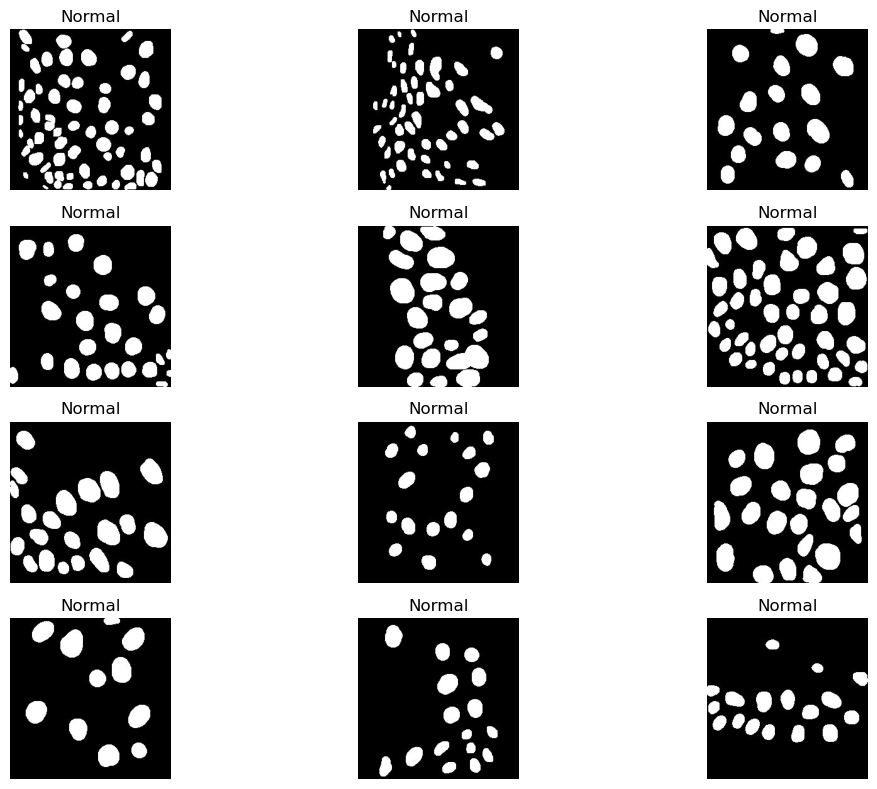

In [17]:
# show the mask images with its class name
def show_mask_with_class(mask_path, class2_name, ax):
    mask = Image.open(mask_path)
    ax.imshow(mask, cmap='gray')
    ax.set_title(class2_name)
    ax.axis('off')

num_images = 12
num_cols = 3 
num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

axes = axes.ravel()

for i, (index, row) in enumerate(data2.iterrows()):
    mask_path = row['file2']
    class2_name = class2_names[row['class2']]

    if i < num_images and i < num_cols * num_rows:
        show_mask_with_class(mask_path, class2_name, axes[i])

plt.tight_layout()
plt.show()


### Mask Image Dataset

In [14]:
# save the mask with its class to local path
folder_path = r'C:\Users\BoonJane\Desktop\oralcancer\mask'
class_names = ['Normal', 'Hyperchromasia', 'Atypical mitotic figure', 'Abnormal variation in nuclear shape'] 

for class_name in class_names:
    class_folder_path = os.path.join(folder_path, class_name)
    files = os.listdir(class_folder_path)

    for i, file_name in enumerate(files, start=0):
        old_file_path = os.path.join(class_folder_path, file_name)
        new_file_name = f"mask_{file_name}"
        new_file_path = os.path.join(class_folder_path, new_file_name)

        os.rename(old_file_path, new_file_path)

        print(f"Renamed: {file_name} to {new_file_name}")

Renamed: image_0.jpg to mask_image_0.jpg
Renamed: image_1.jpg to mask_image_1.jpg
Renamed: image_10.jpg to mask_image_10.jpg
Renamed: image_11.jpg to mask_image_11.jpg
Renamed: image_12.jpg to mask_image_12.jpg
Renamed: image_13.jpg to mask_image_13.jpg
Renamed: image_14.jpg to mask_image_14.jpg
Renamed: image_15.jpg to mask_image_15.jpg
Renamed: image_16.jpg to mask_image_16.jpg
Renamed: image_17.jpg to mask_image_17.jpg
Renamed: image_18.jpg to mask_image_18.jpg
Renamed: image_19.jpg to mask_image_19.jpg
Renamed: image_2.jpg to mask_image_2.jpg
Renamed: image_20.jpg to mask_image_20.jpg
Renamed: image_21.jpg to mask_image_21.jpg
Renamed: image_22.jpg to mask_image_22.jpg
Renamed: image_23.jpg to mask_image_23.jpg
Renamed: image_24.jpg to mask_image_24.jpg
Renamed: image_25.jpg to mask_image_25.jpg
Renamed: image_26.jpg to mask_image_26.jpg
Renamed: image_27.jpg to mask_image_27.jpg
Renamed: image_28.jpg to mask_image_28.jpg
Renamed: image_29.jpg to mask_image_29.jpg
Renamed: image_3.

# Model Training

## Segmentation Model (RGB Augmented Dataset and Grayscale Augmented Dataset) 
both dataset evaluate with Groundtruth Augmented Dataset

### U-Net Segmentation Modelling 

### Seg-Net Segmentation Modelling

### ResNet Segmentation Modelling

## Classification Model (RGB Augmented Dataset and Grayscale Augmented Dataset)
- extract features and classify 
- compare which dataset give better result by comparing accuracy, precision and recall

### Random Forest

### Naive Bayes

### SVM